In [2]:
from line_follower import LineFollower
import cv2
import os
import yaml

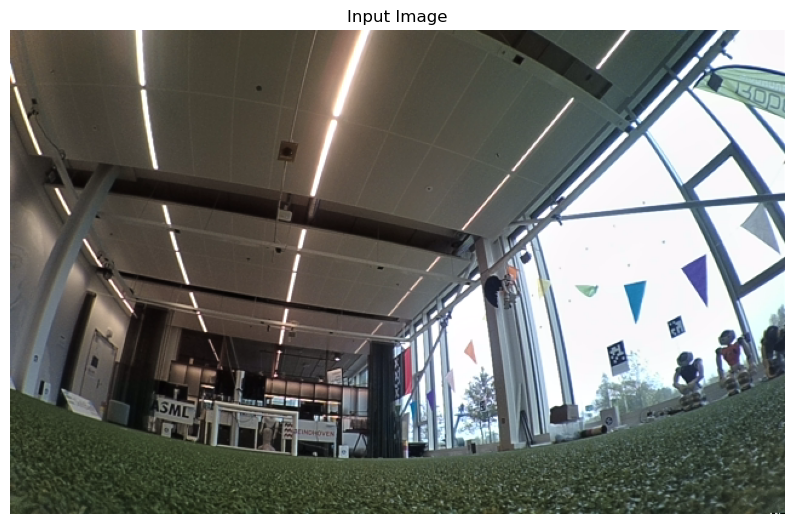

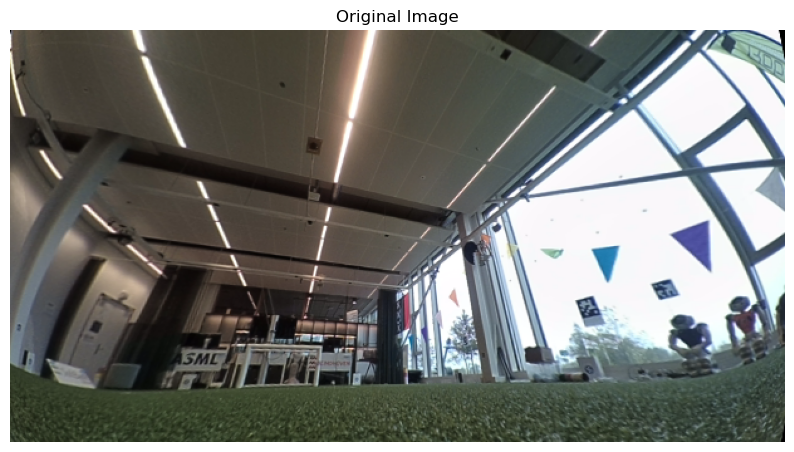

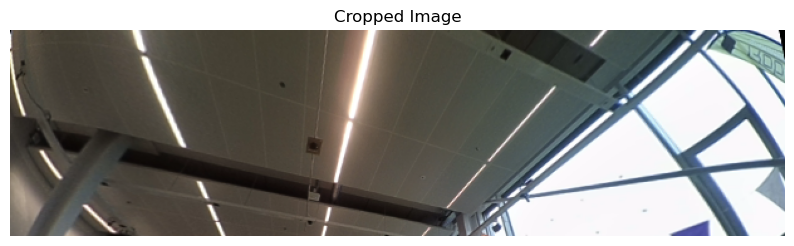

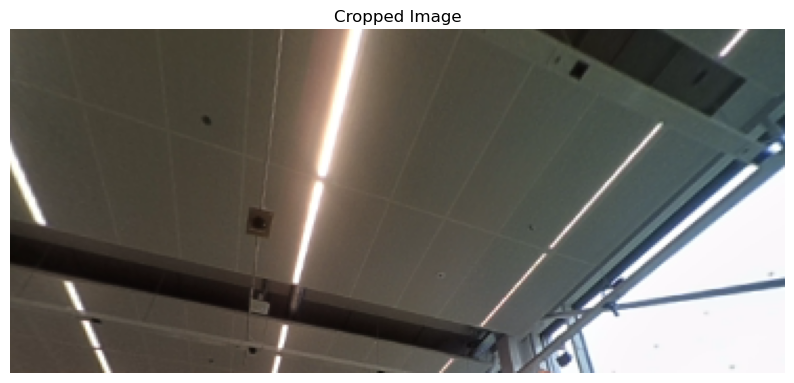

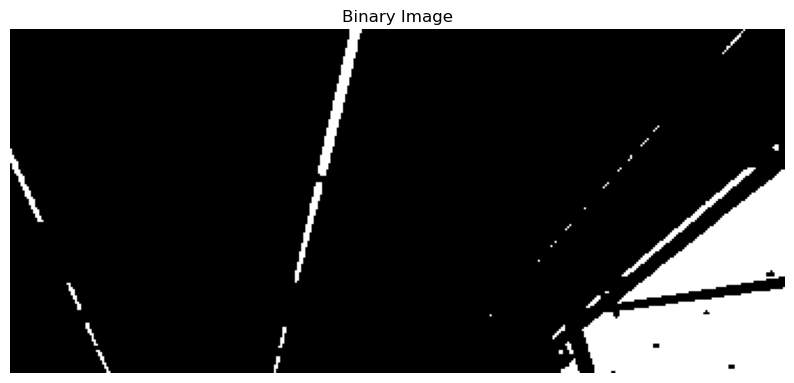

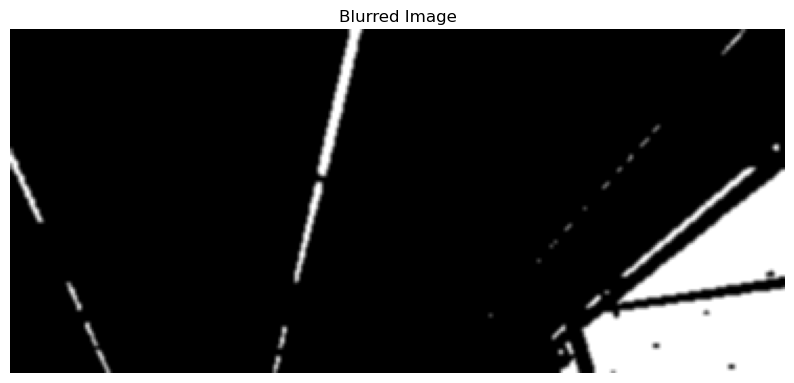

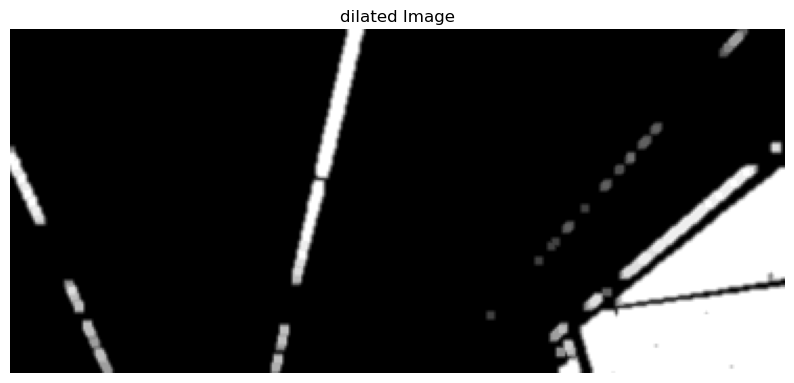

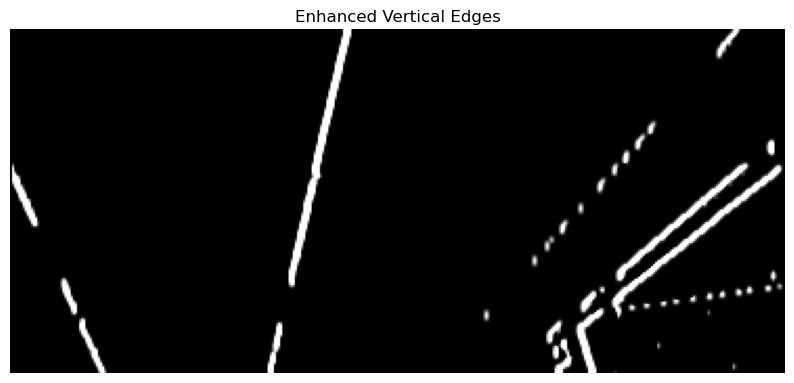

Found line with length 125.31959144523253 and angle 78.95905981967627
Discarding line with length 139.31259813814398 and angle 39.17365797044423
Discarding line with length 136.49908424601244 and angle 39.053136946026505
Discarding line with length 140.089257261219 and angle 38.91530613473125
Discarding line with length 140.089257261219 and angle 38.91530613473125
Discarding line with length 140.089257261219 and angle 38.91530613473125
Discarding line with length 112.58774356030055 and angle 77.69198418257209
Found line with length 156.51836952894698 and angle 77.82854179141253
Discarding line with length 140.5844941663198 and angle 39.80557109226519
Discarding line with length 105.60303025955268 and angle 65.37643521383639
Discarding line with length 182.70194306574848 and angle 48.10602709561643
Discarding line with length 180.54639292990598 and angle 47.918434720781555
Discarding line with length 176.30938715791623 and angle 47.988632455229464
Discarding line with length 96.74709297

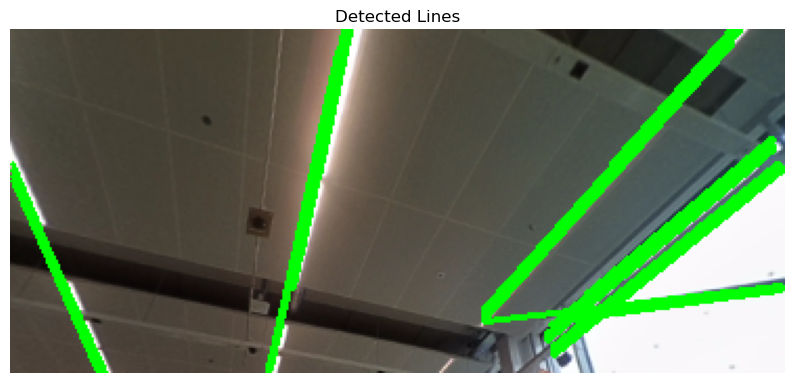

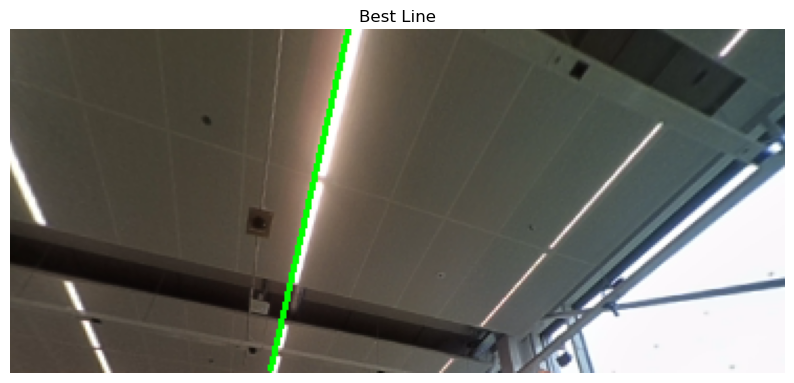

Turning left with: 0.07147443245583444 rad/s
Old action: (0.3, 0.0) -> New action: (0.3, 0.02858977298233378)


(0.3, 0.02858977298233378)

In [ ]:
config_path = os.path.join(
    "..",
    "..",
    "..",
    "configs",
    "lab1",
    "line_follower_config.yaml",
)
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

l = LineFollower(config)
img = cv2.imread("../../../video/initial_image_30.png")  # normal video  12  30  40  old video 12 40 (41 for length)
# img = cv2.flip(img, 1)
l.pipeline(img)

In [3]:
%load_ext autoreload
%autoreload 2